# bench

> This module conducts benchmarking of various sorting algorithms acorss various data and compute paradigms

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#| default_exp bench

In [ ]:
#| export
from __future__ import annotations

In [ ]:
#| hide
from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
#| export
from fastcore.utils import *


# setup

In [ ]:
#| export
from fastcore.xtras import globtastic
from importlib import import_module
import sys, os
from pathlib import Path

In [ ]:
#| export
def get_algs(fldr, filter_file, incl_file='*.py', excl_fldr='excl'):
    algs = [] #all sorting algos to be used
    fps = globtastic(path = fldr, file_glob=incl_file, file_re=filter_file, skip_folder_re=excl_fldr)
    for fp in fps:
        *fldr, fl = fp.split("/")
        alg, _ = fl.split(".")
        algs.append(alg)
    return algs
#print(arr)

In [ ]:
#| export
def _get_scope(fldr, dist_families, nV):
    *_, alg_type = fldr.split('/')
    algs = get_algs(fldr, filter_file=alg_type)
    sys.path.append(os.path.join(Path.cwd(), os.pardir, alg_type))
    modul = {alg: import_module(alg) for alg in algs}
    #distributions of data that need to be sorted
    fams = [d for d in dist_families if d in ["float","int","normal","lognormal","binomial","exponential","range"]]
    sds = list(range(nV)) #variations for given distribution
    return alg_type, algs, modul, fams, sds

# runs

In [ ]:
#| export
from fastcore.parallel import parallel
import numpy as np
from collections import namedtuple

In [ ]:
#| export
def gen(fam: str|None=None, # distribution family
        n: int=0, # array of size
        sd: int=0, # random seed
        )->np.ndarray|list: # generate data

    np.random.seed(sd)

    if fam == "float":
        val = np.random.random(n)
    elif fam == "int":
        val = np.random.randint(low=n*(-100), high=n*100, size=n)
    elif fam == "normal":
        val = np.random.randn(n)
    elif fam == "lognormal":
        val = np.random.lognormal(size=n)
    elif fam == "binomial":
        val = np.random.binomial(10*n, 0.5, size=n)
    elif fam == "exponential":
        val = np.random.exponential(size=n)
    else: #"range"
        start = -int(n/2); stop = start + n
        val = list(reversed(range(start, stop)))

    return val

    # exponential (λ)

In [ ]:
test_eq(gen(),[])
test_eq(gen(n=1),[0])
test_eq(gen(n=3),[1,0,-1])

In [ ]:
#| export
def _run_alg(distn, modul, typ, task, **kwargs):
    #print(distn, modul, typ, task, kwargs)
    alg, dat = task.alg, task.dat
    arr = distn.setdefault(dat, gen(dat.fam,dat.sz,dat.sd))
    #modul[alg].sort(arr)
    if modul:
        algo = getattr(modul[alg], typ)
        res = algo(arr, **kwargs)
    #print(res, arr)

In [ ]:
#| export
import time

In [ ]:
#| export

def _timeit(method):
    def timed(*args, **kwargs):
        ts = time.time()
        result = method(*args, **kwargs)
        te = time.time()
        return  (te - ts) * 1000 / (result if result>0 else 1) #avg time per task in milli seconds
    return timed

In [ ]:
#| export
@_timeit
def _run(tasks, distn, modul, typ, sub_szs, sub_algs, sub_fams, **kwargs):
    sub_tasks = [task for task in tasks if task.dat.sz in sub_szs and task.alg in sub_algs and task.dat.fam in sub_fams]
    parallel(_run_alg, sub_tasks, distn, modul, typ, **kwargs, threadpool=False, progress=False, n_workers=0) # variations run in parallel depending on #cpu-cores
    return len(sub_tasks)

# plots

In [ ]:
#| export
import matplotlib.pyplot as plt

In [ ]:
#| export
# plot for given order of magnitude, performance by algorithms and optionally by data distributions
def plot(sz, runs, algs, fams, typ):
    fig, ax = plt.subplots()
    ax.set_title(f'Benchmark by {typ} alg for data of size {sz}')
    ax.set_ylabel('Run times (ms)')
    ax.set_xticks(range(len(algs)), algs, rotation = 'vertical')
    width = 0.2
    for i, fam in enumerate(fams,-int(0.5*len(fams))):
        run_times = [runs[sz, alg, fam] for alg in algs]
        ax.bar(np.arange(len(algs))+i*width, run_times, width ,label=f'{fam}')
    ax.legend(fontsize='xx-small')
    
    fig.tight_layout()
    plt.show()

# main

In [ ]:
#| export
def benchmark(alg_fldr, data_sizes=[10], dist_families=["float","int","normal","lognormal","binomial","exponential","range"] , num_variations=1, **kwargs):
    typ, algs, modul, fams, sds, szs = *_get_scope(alg_fldr, dist_families, num_variations), data_sizes
    
    Dat = namedtuple('Dat',['fam', 'sz', 'sd'])
    dats = [dat:=Dat(fam, sz, sd) for fam in fams for sz in szs for sd in sds]
    
    Task = namedtuple('Task',['alg', 'dat'])
    tasks = [task:=Task(alg, dat) for alg in algs for dat in dats]  
    
    # run-times for all compute paradigms
    distn = {};
    runs = {(sz, alg, fam): _run(tasks, distn, modul, typ, [sz], [alg], [fam], **kwargs) for sz in szs for alg in algs for fam in fams}

    #plot
    for sz in szs:
        plot(sz, runs, algs, fams, typ)



In [ ]:
#| export
from fastcore.script import *
#@call_parse
def main(fldr:str,     # The relative path to folder which contain all algorithms to run
         **kwargs):    # Optional parameters that the algorithm take
    "Benchmark and plot runtime performance of algorithms stored in `fldr`, and optionally provide additional prameters for the algorithm"
    #benchmark('../search', target=1)
    #benchmark('../sort')
    benchmark(fldr, **kwargs)


# usage

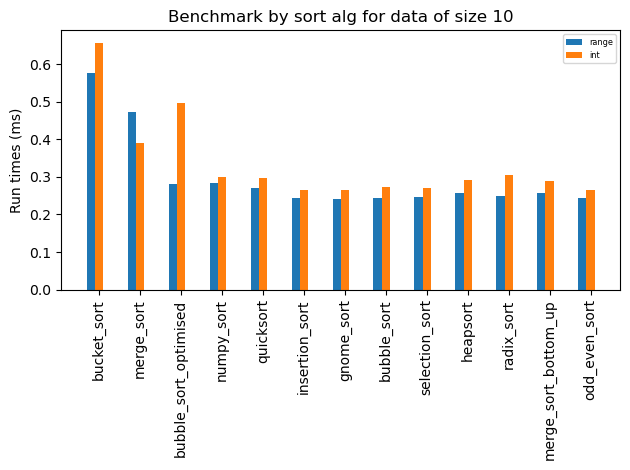

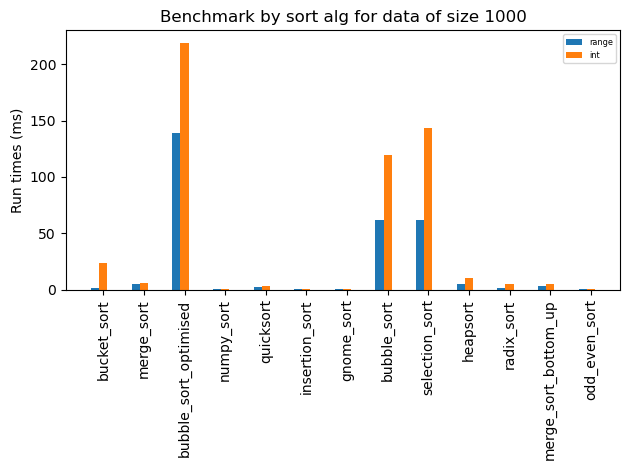

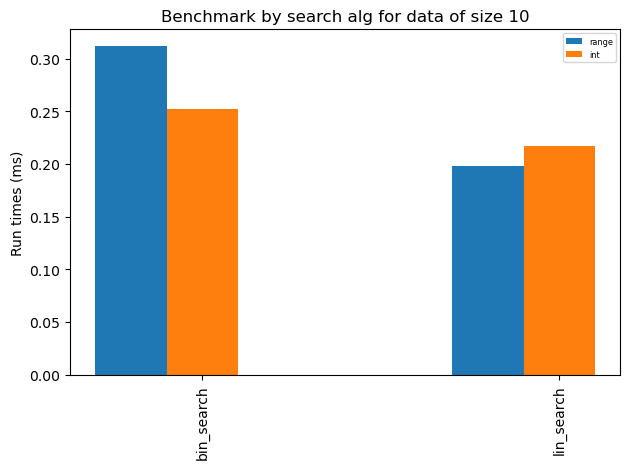

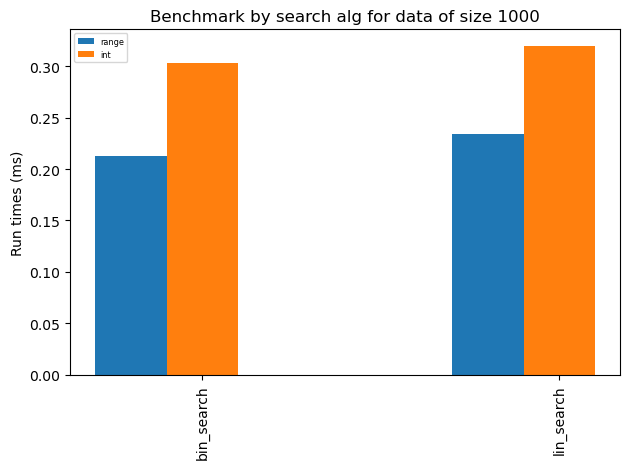

In [ ]:
main('../sort', data_sizes=[10, 1000], dist_families=["range","int"])
main('../search', data_sizes=[10, 1000], dist_families=["range","int"])

In [ ]:
test_eq(1+1,2)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()